In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [16]:
base_path = "/userhome/34/h3567721/projects/Depth/GeoNet-ori/predictions/checkpoint_depth/model-150000"

In [3]:
def bilinear_sampler(imgs, coords):
  """Construct a new image by bilinear sampling from the input image.

  Points falling outside the source image boundary have value 0.

  Args:
    imgs: source image to be sampled from [batch, height_s, width_s, channels]
    coords: coordinates of source pixels to sample from [batch, height_t,
      width_t, 2]. height_t/width_t correspond to the dimensions of the output
      image (don't need to be the same as height_s/width_s). The two channels
      correspond to x and y coordinates respectively.
  Returns:
    A new sampled image [batch, height_t, width_t, channels]
  """
  def _repeat(x, n_repeats):
    rep = tf.transpose(
        tf.expand_dims(tf.ones(shape=tf.stack([
            n_repeats,
        ])), 1), [1, 0])
    rep = tf.cast(rep, 'float32')
    x = tf.matmul(tf.reshape(x, (-1, 1)), rep)
    return tf.reshape(x, [-1])

  with tf.name_scope('image_sampling'):
    coords_x, coords_y = tf.split(coords, [1, 1], axis=3)
    inp_size = imgs.get_shape()
    coord_size = coords.get_shape()
    out_size = coords.get_shape().as_list()
    out_size[3] = imgs.get_shape().as_list()[3]

    coords_x = tf.cast(coords_x, 'float32')
    coords_y = tf.cast(coords_y, 'float32')

    x0 = tf.floor(coords_x)
    x1 = x0 + 1
    y0 = tf.floor(coords_y)
    y1 = y0 + 1

    y_max = tf.cast(tf.shape(imgs)[1] - 1, 'float32')
    x_max = tf.cast(tf.shape(imgs)[2] - 1, 'float32')
    zero = tf.zeros([1], dtype='float32')

    x0_safe = tf.clip_by_value(x0, zero, x_max)
    y0_safe = tf.clip_by_value(y0, zero, y_max)
    x1_safe = tf.clip_by_value(x1, zero, x_max)
    y1_safe = tf.clip_by_value(y1, zero, y_max)

    ## bilinear interp weights, with points outside the grid having weight 0
    # wt_x0 = (x1 - coords_x) * tf.cast(tf.equal(x0, x0_safe), 'float32')
    # wt_x1 = (coords_x - x0) * tf.cast(tf.equal(x1, x1_safe), 'float32')
    # wt_y0 = (y1 - coords_y) * tf.cast(tf.equal(y0, y0_safe), 'float32')
    # wt_y1 = (coords_y - y0) * tf.cast(tf.equal(y1, y1_safe), 'float32')

    wt_x0 = x1_safe - coords_x
    wt_x1 = coords_x - x0_safe
    wt_y0 = y1_safe - coords_y
    wt_y1 = coords_y - y0_safe

    ## indices in the flat image to sample from
    dim2 = tf.cast(inp_size[2], 'float32')
    dim1 = tf.cast(inp_size[2] * inp_size[1], 'float32')
    base = tf.reshape(
        _repeat(
            tf.cast(tf.range(coord_size[0]), 'float32') * dim1,
            coord_size[1] * coord_size[2]),
        [out_size[0], out_size[1], out_size[2], 1])

    base_y0 = base + y0_safe * dim2
    base_y1 = base + y1_safe * dim2
    idx00 = tf.reshape(x0_safe + base_y0, [-1])
    idx01 = x0_safe + base_y1
    idx10 = x1_safe + base_y0
    idx11 = x1_safe + base_y1

    ## sample from imgs
    imgs_flat = tf.reshape(imgs, tf.stack([-1, inp_size[3]]))
    imgs_flat = tf.cast(imgs_flat, 'float32')
    im00 = tf.reshape(tf.gather(imgs_flat, tf.cast(idx00, 'int32')), out_size)
    im01 = tf.reshape(tf.gather(imgs_flat, tf.cast(idx01, 'int32')), out_size)
    im10 = tf.reshape(tf.gather(imgs_flat, tf.cast(idx10, 'int32')), out_size)
    im11 = tf.reshape(tf.gather(imgs_flat, tf.cast(idx11, 'int32')), out_size)

    w00 = wt_x0 * wt_y0
    w01 = wt_x0 * wt_y1
    w10 = wt_x1 * wt_y0
    w11 = wt_x1 * wt_y1

    output = tf.add_n([
        w00 * im00, w01 * im01,
        w10 * im10, w11 * im11
    ])
    return output


In [4]:
def flow_warp(src_img, flow):
  """ inverse warp a source image to the target image plane based on flow field
  Args:
    src_img: the source  image [batch, height_s, width_s, 3]
    flow: target image to source image flow [batch, height_t, width_t, 2]
  Returns:
    Source image inverse warped to the target image plane [batch, height_t, width_t, 3]
  """
  batch, height, width, _ = src_img.get_shape().as_list()
  tgt_pixel_coords = tf.transpose(meshgrid(batch, height, width, False),
                     [0, 2, 3, 1])
          
  src_pixel_coords = tgt_pixel_coords + flow

  output_img = bilinear_sampler(src_img, src_pixel_coords)
  
  return output_img

In [5]:
# self.fwd_rigid_warp_pyramid = [flow_warp(self.src_image_concat_pyramid[s], self.fwd_rigid_flow_pyramid[s]) \
#                                       for s in range(opt.num_scales)]
# self.bwd_rigid_warp_pyramid = [flow_warp(self.tgt_image_tile_pyramid[s], self.bwd_rigid_flow_pyramid[s]) \
#                                       for s in range(opt.num_scales)]

In [33]:
def make_color_wheel():
    """
    Generate color wheel according Middlebury color code
    :return: Color wheel
    """
    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros([ncols, 3])

    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.transpose(np.floor(255*np.arange(0, RY) / RY))
    col += RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - np.transpose(np.floor(255*np.arange(0, YG) / YG))
    colorwheel[col:col+YG, 1] = 255
    col += YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.transpose(np.floor(255*np.arange(0, GC) / GC))
    col += GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - np.transpose(np.floor(255*np.arange(0, CB) / CB))
    colorwheel[col:col+CB, 2] = 255
    col += CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.transpose(np.floor(255*np.arange(0, BM) / BM))
    col += + BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - np.transpose(np.floor(255 * np.arange(0, MR) / MR))
    colorwheel[col:col+MR, 0] = 255

    return colorwheel

def compute_color(u, v):
    """
    compute optical flow color map
    :param u: optical flow horizontal map
    :param v: optical flow vertical map
    :return: optical flow in color code
    """
    [h, w] = u.shape
    img = np.zeros([h, w, 3])
    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = make_color_wheel()
    ncols = np.size(colorwheel, 0)

    rad = np.sqrt(u**2+v**2)

    a = np.arctan2(-v, -u) / np.pi

    fk = (a+1) / 2 * (ncols - 1) + 1

    k0 = np.floor(fk).astype(int)

    k1 = k0 + 1
    k1[k1 == ncols+1] = 1
    f = fk - k0

    for i in range(0, np.size(colorwheel,1)):
        tmp = colorwheel[:, i]
        col0 = tmp[k0-1] / 255
        col1 = tmp[k1-1] / 255
        col = (1-f) * col0 + f * col1

        idx = rad <= 1
        col[idx] = 1-rad[idx]*(1-col[idx])
        notidx = np.logical_not(idx)

        col[notidx] *= 0.75
        img[:, :, i] = np.uint8(np.floor(255 * col*(1-nanIdx)))

    return img

def flow_to_image(flow):
    """
    Convert flow into middlebury color code image
    :param flow: optical flow map
    :return: optical flow image in middlebury color
    """
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999.
    maxv = -999.
    minu = 999.
    minv = 999.
    UNKNOWN_FLOW_THRESH = 1e7
    SMALLFLOW = 0.0
    LARGEFLOW = 1e8

    idxUnknow = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknow] = 0
    v[idxUnknow] = 0

    maxu = max(maxu, np.max(u))
    minu = min(minu, np.min(u))

    maxv = max(maxv, np.max(v))
    minv = min(minv, np.min(v))

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(-1, np.max(rad))

    u = u/(maxrad + np.finfo(float).eps)
    v = v/(maxrad + np.finfo(float).eps)

    img = compute_color(u, v)

    idx = np.repeat(idxUnknow[:, :, np.newaxis], 3, axis=2)
    img[idx] = 0

    return np.uint8(img)

In [38]:
def plot_image(file_name):
    tgt_image = np.load(os.path.join(base_path, "tgt_image", file_name))
    depth = np.load(os.path.join(base_path, "depth", file_name))
    src_image_stack = np.load(os.path.join(base_path, "src_image_stack", file_name))
    
    bwd_rigid_error = np.load(os.path.join(base_path, "bwd_rigid_error", file_name))
    fwd_rigid_error = np.load(os.path.join(base_path, "fwd_rigid_error", file_name))
    
    bwd_rigid_warp = np.load(os.path.join(base_path, "bwd_rigid_warp", file_name))
    fwd_rigid_warp = np.load(os.path.join(base_path, "fwd_rigid_warp", file_name))
    
    bwd_rigid_flow = np.load(os.path.join(base_path, "bwd_rigid_flow", file_name))
    fwd_rigid_flow = np.load(os.path.join(base_path, "fwd_rigid_flow", file_name))
    
#     fwd_rigid_flow = compute_rigid_flow(......, reverse_pose=False)
#         Flow: from tgt to src
#     bwd_rigid_flow = compute_rigid_flow(......, reverse_pose=True)
#         Flow: from src to tgt
#     fwd_rigid_warp = flow_warp(src, fwd_rigid_flow)
#         Warp: from src to tgt
#     bwd_rigid_warp = flow_warp(tgt, bwd_rigid_flow)
#         Warp: from tgt to src
    
    plt.figure(figsize=(18,18))
    plt.subplot(6,3,1)
    plt.imshow((src_image_stack[0,:,:,0:3]+1)/2)
    plt.title("src_1")

    plt.subplot(6,3,2)
    plt.imshow((tgt_image[0]+1)/2) # t
    plt.title("tgt")

    plt.subplot(6,3,3)
    plt.imshow((src_image_stack[0,:,:,3:6]+1)/2)
    plt.title("src_2")

    plt.subplot(6,3,4)
    plt.imshow(1.0/depth[1,:,:,0], cmap="plasma")
    plt.title("src_1_depth")

    plt.subplot(6,3,5)
    plt.imshow(1.0/depth[0,:,:,0], cmap="plasma")
    plt.title("tgt_depth")

    plt.subplot(6,3,6)
    plt.imshow(1.0/depth[2,:,:,0], cmap="plasma")
    plt.title("src_2_depth")

    plt.subplot(6,3,7)
    plt.imshow((fwd_rigid_warp[0]+1)/2)
    plt.title("fwd warp: src_1->tgt")

    plt.subplot(6,3,8)
    plt.imshow((fwd_rigid_warp[1]+1)/2)
    plt.title("fwd warp: src_2->tgt")
    
    plt.subplot(6,3,9)
    plt.imshow(flow_to_image(fwd_rigid_flow[0]))
    plt.title("fwd flow: tgt-src_1")

    plt.subplot(6,3,10)
    plt.imshow((bwd_rigid_warp[0]+1)/2)
    plt.title("bwd warp: tgt->src_1")

    plt.subplot(6,3,11)
    plt.imshow((bwd_rigid_warp[1]+1)/2)
    plt.title("bwd warp: tgt->src_2")
    
    plt.subplot(6,3,12)
    plt.imshow(flow_to_image(fwd_rigid_flow[1]))
    plt.title("fwd flow: tgt-src_2")

    plt.subplot(6,3,13)
    plt.imshow(fwd_rigid_error[0])
    plt.colorbar()
    plt.title("fwd err: src_1->tgt vs tgt")

    plt.subplot(6,3,14)
    plt.imshow(fwd_rigid_error[1])
    plt.colorbar()
    plt.title("fwd err: src_2->tgt vs tgt")  
    
    plt.subplot(6,3,15)
    plt.imshow(flow_to_image(bwd_rigid_flow[0]))
    plt.title("bwd flow: src_1-tgt")

    plt.subplot(6,3,16)
    plt.imshow(bwd_rigid_error[0])
    plt.colorbar()
    plt.title("bwd err: tgt->src_1 vs src_1")

    plt.subplot(6,3,17)
    plt.imshow(bwd_rigid_error[1])
    plt.colorbar()
    plt.title("bwd err: tgt->src_2 vs sr_2")
    
    plt.subplot(6,3,18)
    plt.imshow(flow_to_image(bwd_rigid_flow[1]))
    plt.title("bwd flow: src_2-tgt")

    plt.show()
    plt.close()

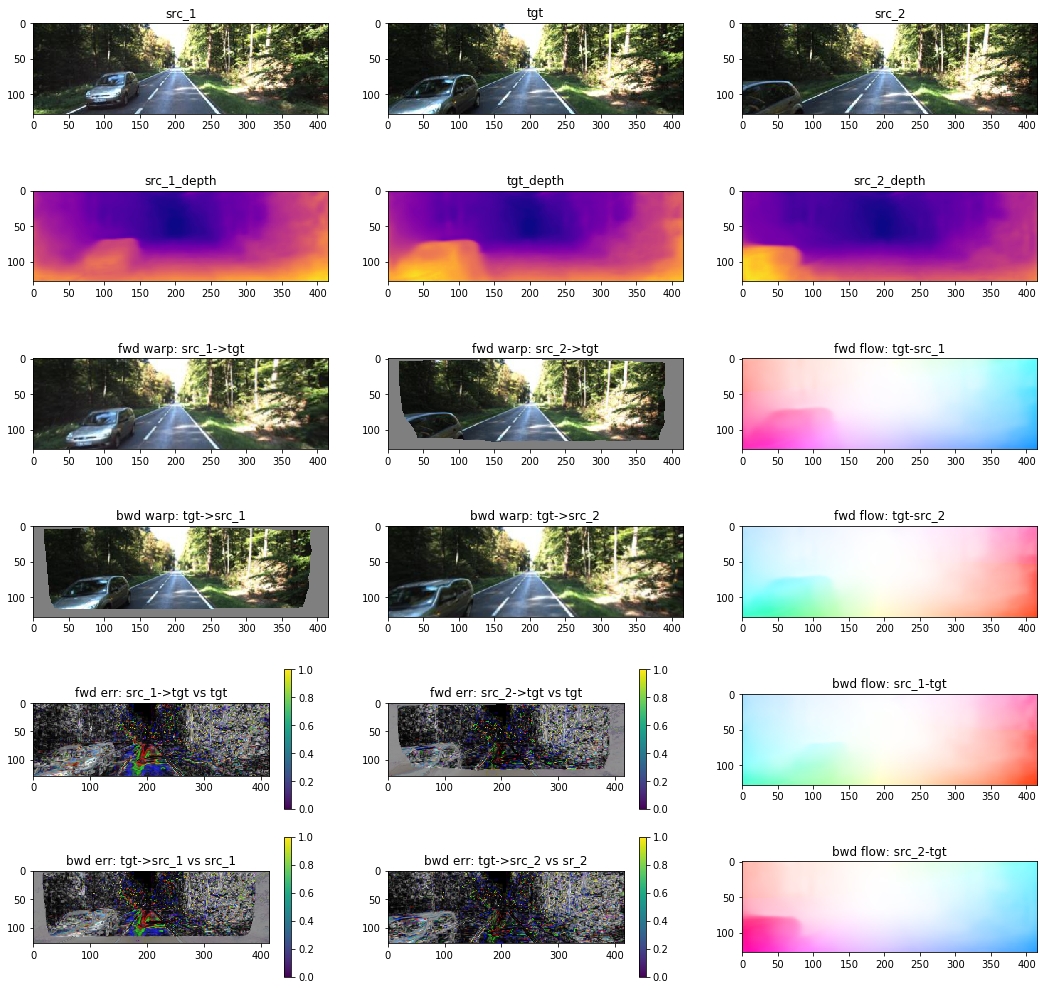

In [39]:
plot_image("2011_09_26_drive_0027_sync_02_0000000007.npy")